# Surface Code and Quantum Error Correction

## Basic Error Correction
Quantum error correction is essential for protecting quantum information from errors due to decoherence and other quantum noise. The basic idea is to encode a logical qubit into a larger number of physical qubits in such a way that errors can be detected and corrected.

In quantum error correction, the code distance is a crucial parameter that measures the robustness of a quantum error-correcting code. It is defined as the minimum number of qubits that need to be altered to transform one valid codeword into another. Essentially, it represents the minimum weight of an error that can cause a logical error in the code.

Here are some notes and definitions that will be relevant in this notebook:
- **Quantum Error-Correction (QEC)**: This is a method used to protect quantum information from errors due to decoherence and other quantum noise. It involves encoding the quantum information of a single logical qubit into a larger Hilbert space using additional physical qubits.

- **Code Distance ($d$)**: The code distance is the smallest number of qubits that must be manipulated to change one logical qubit into another. It is a measure of the code's ability to detect and correct errors. A higher code distance means the code can detect and correct more errors.

- **Error Detection and Correction**: A code-distance $d$ QEC code can detect up to $(d-1)$ errors and correct up to $(\left\lfloor \frac{d-1}{2} \right\rfloor)$ errors.

- **Logical Qubits and Physical Qubits**: In a QEC, logical qubits are the qubits that store the actual quantum information, while physical qubits are the qubits used to encode the logical qubits. The code distance is related to the number of physical qubits used to protect each logical qubit. For example, in the case of the well-known Shor code, which encodes one logical qubit into nine physical qubits, the code distance is 3. This means that it can correct any single-qubit error.

- **Syndrome Measurements and Stabilizers**: Syndrome measurements are used to detect errors without collapsing the quantum state. Measurements project the state onto the eigenstates of certain operators called stabilizers. These stabilizers are chosen so that the projection onto their eigenstate manifolds does not perturb the state of the logical qubit. By reading the measurement outcome we can determine the type and location of errors. For example, in the case of bit-flip errors, we measure the parity of certain qubits, and the parity operator is a stabilizer.


![alt text](surface.png)


## Surface Code
The surface code is a type of topological quantum error-correcting code that arranges qubits on a 2D lattice. For a thorough treatment of this topic please read [Surface code quantum computing by lattice surgery](https://iopscience.iop.org/article/10.1088/1367-2630/14/12/123011), from which we reproduce the above depiction of the surface patch. As seen on the figure above the code is arranged into data and measurement qubits. In the figure above the data qubits and measurement qubits are depicted using large and small spheres respectively. The entire patch depicted is capable of storing one logical qubit - this is a so-called patch qubit. As the names imply, data qubits are used to carry the data of the logical qubit, while the measurement qubits are used for syndrome measurements.

### Face and Vertex plaquettes
Face plaquettes are defined as
$$ A = \prod_{i \in F} Z_i $$
where $ Z_i $ is the Pauli-Z operator acting on qubit $i$. Vertex plaquettes are defined as
$$ B = \prod_{i \in V} X_i $$
where $ X_i $ is the Pauli-X operator acting on qubit $i$. These are the stabilizers of the code and they are continuously measured in order to produce syndromes and detect errors. The surface code does not directly correct errors by applying quantum gates to correct them, instead classical post-processing applied to subsequent measurement outcomes is used to correct future measurements.

## Quantum Information Storage and Manipulation on the Surface Code
It may seem that due to the large number of stabilizers the projection on to the stabilizer states should destroy the quantum information contained in the surface patch, however there is some quantum information left invariant by the stabilizers. To see this, we can define
$$
Z_L = \prod_{i \in L_v}
$$
where the product is taken over a line of data-qubits vertically and
$$
X_L = \prod_{i \in L_h}
$$
where the relevant line is horizontal. These two operators together with $Y_L = iX_LZ_L$ generate an $SU(2)$ algebra and so can be used to encode information corresponding to a single logical qubit. Moreover, they commute with all of the stabilizers and are therefore not affected by projection onto the stabilizer manifold. The logical qubit is therefore in a sense stored in aggregate on the edges of the patch and we can manipulate it by deforming and applying quantum gates to the data-qubits on the vertical and horizontal edges respectively.

One prominent method to do this is the so-called lattice-surgery protocol which performs operations on patch-qubits by rotating them or resizing them. Two-qubit operations can be carried out by merging and then splitting qubits after appropriately aligning their edges. Multi-qubit operations can be carried out by aligning edges of several patches with an ancilla patch, that is measured in order to implement gate-teleportation, and so on. The strength of lattice surgery is that these operations can be implemented while QEC is continuously carried out at some desired minimum code distance $d$. Ancilla qubits in the $|0>$, $|1>$ or  $|+>$, $|->$ states can be prepared by initializing states and applying transversal gates, and from there Clifford gates can be implemented using gate teleportation with lattice surgery.

However, arbitrary quantum computing needs to implement the T-gate in addition to the Clifford set, and because of that one additional ancilla state is needed. This is the so-called magic state. Most of the overhead of surface code quantum computing is attribute to generating good magic states through a protocol called magic state distillation. A device implementing the surface code therefore must have a dedicated footprint that continuously produces magic states to be consumed by the rest of the circuit.

## Solovay-Kitaev Decomposition
The Solovay-Kitaev theorem states that any quantum gate can be approximated to arbitrary accuracy using a finite set of universal gates. The Solovay-Kitaev algorithm provides a method to decompose a given unitary operation into a sequence of gates from this universal set.

## Magic State Distillation
Magic state distillation is a process used to produce high-fidelity quantum states (magic states) that are necessary for implementing certain quantum gates, such as the T-gate, in a fault-tolerant manner. The process involves preparing multiple noisy copies of a magic state and then using error correction techniques to distill a smaller number of higher-fidelity magic states.

In summary, the surface code and related techniques like syndrome measurements, Solovay-Kitaev decomposition, and magic state distillation are crucial components of fault-tolerant quantum computation. They enable the reliable execution of quantum algorithms despite the presence of errors and noise.

In [4]:
from quri_vm import VM
from quri_parts.backend.devices import clifford_t_device
from quri_parts.backend.device import DeviceProperty
from quri_parts.backend.units import TimeUnit, TimeValue

def get_vm(qubit_count: int=8, code_distance: int=7, qec_cycle_us: float=1.0, delta_sk: float=1.0e-4, physical_error_rate: float=0.7e-4, mode_block: str = "compact") -> tuple[VM, DeviceProperty]:
    device_prop = clifford_t_device.generate_device_property(
        qubit_count=qubit_count,
        code_distance=code_distance,
        qec_cycle=TimeValue(qec_cycle_us, TimeUnit.MICROSECOND),
        delta_sk=delta_sk,
        physical_error_rate=physical_error_rate,
        mode_block=mode_block
    )
    return VM.from_device_prop(device_prop), device_prop


## Problem setup

We will set up the problem that we will simulate. This is going to be the Heisenberg model without any anisotropies. First let us set it up and then see how the circuit depth depends on the number of Trotter steps chosen for the time-evolution.

In [5]:
from functools import cache

from quri_algo.circuit.time_evolution.trotter_time_evo import TrotterTimeEvolutionCircuitFactory
from quri_algo.problem import QubitHamiltonianInput
from quri_parts.circuit import NonParametricQuantumCircuit
from quri_parts.core.operator import Operator, pauli_label

def get_operator(qubit_count: int) -> Operator:
    op = Operator()
    for q in range(qubit_count):
        for p in ['X', 'Y', 'Z']:
            op.add_term(pauli_label(p + str(q) + ' ' + p + str((q+1)%qubit_count)), 1.0)
    
    return op

class HeisenbergTimeEvolutionCircuitFactory:
    """Time-evolution circuit factory
    
    This class wraps TrotterTimeEvolutionCircuitFactory and allows creating circuits specifically for the Heisenberg model by calling it with the qubit count and evolution time"""
    # Return a time-evolution circuit factory and cache it
    @cache
    def get_circuit_factory(self, qubit_count:int, n_trotter: int) -> TrotterTimeEvolutionCircuitFactory:
        operator = get_operator(qubit_count)
        hamiltonian_input = QubitHamiltonianInput(qubit_count, operator)

        return TrotterTimeEvolutionCircuitFactory(hamiltonian_input, n_trotter)

    def __call__(
        self, evolution_time: float, qubit_count: int, n_trotter: int
    ) -> NonParametricQuantumCircuit:
        circuit_factory = self.get_circuit_factory(qubit_count, n_trotter)
        return circuit_factory(evolution_time=evolution_time)

## Solovay-Kitaev decomposition

In order to implement logical quantum circuits fault tolerantly, they must first be converted into circuits that can be run using the surface code. The process by which we do so is the Solovay-Kitaev decomposition, a circuit decomposition which results in approximate quantum circuits. As we shall see, they result in pretty good circuit decompositions overall.

Things to note
- The SK-decomposition is handled at the logical level, i.e. it is device independent. That means that in a typical application we would pick the SK-precision depending on what suits the given device characteristics best based on simulations.
- SK-decomposition affects both circuit execution time AND fidelity and when choosing the required precision the user faces a trade-off between the two.

In [6]:
from quri_algo.core.cost_functions import HilbertSchmidtTest
from quri_algo.circuit.time_evolution.exact_unitary import ExactUnitaryTimeEvolutionCircuitFactory
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator

N_QUBITS = 8
EVOLUTION_TIME = 0.5
TROTTER_STEPS = [1, 3, 10, 30, 100]
SK_EXPONENTS = [-2, -3, -4, -5, -6]


estimator = create_qulacs_vector_estimator()
hs_test = HilbertSchmidtTest(estimator)

circuit_factory = HeisenbergTimeEvolutionCircuitFactory()
circuit_factory_exact = ExactUnitaryTimeEvolutionCircuitFactory(QubitHamiltonianInput(N_QUBITS,get_operator(N_QUBITS)))

fidelities = []
hs_cost = []
execution_time = []

for n_t in TROTTER_STEPS:
    time_evo_exact = circuit_factory_exact(EVOLUTION_TIME)
    latencies = {}
    fidelity = {}
    time_evo_trotter = circuit_factory(EVOLUTION_TIME, N_QUBITS, n_t)
    for e in SK_EXPONENTS:
        vm, _ = get_vm(qubit_count=N_QUBITS, delta_sk=10**e)
        time_evo_trotter_transpiled = vm.transpile(time_evo_trotter)
        analysis = vm.analyze(time_evo_trotter_transpiled)
        fidelity[e] = analysis.fidelity
        latencies[e] = vm.analyze(time_evo_trotter_transpiled).latency
    time_evo_trotter = circuit_factory(EVOLUTION_TIME, N_QUBITS, n_t)
    hs_cost.append(hs_test(time_evo_exact,time_evo_trotter))
    fidelities.append(fidelity)
    execution_time.append(latencies)


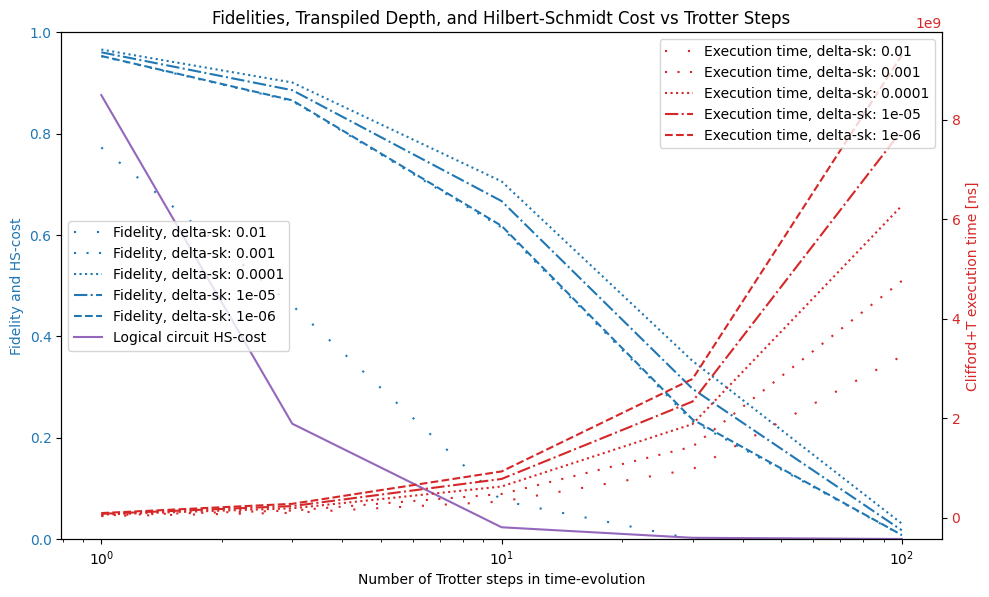

In [7]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:blue'
linestyles = {
    0: '-',
    -2: (0, (1, 10)),
    -3: (0, (1, 5)),
    -4: ':',
    -5: '-.',
    -6: '--',
}

ax1.set_ylabel('Fidelity and HS-cost', color=color)
ax1.set_xlabel('Number of Trotter steps in time-evolution')
for e in SK_EXPONENTS:
    ax1.plot(TROTTER_STEPS, [fidelity[e] for fidelity in fidelities], label=f'Fidelity, delta-sk: {10**e}', color=color, linestyle=linestyles[e])
ax1.semilogx(TROTTER_STEPS, [hs.value.real for hs in hs_cost], label=f'Logical circuit HS-cost', color='tab:purple', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ybound(0.0, 1.0)
ax1.legend(loc='center left')

color = 'tab:red'
ax2 = ax1.twinx()
ax2.set_xlabel('Number of Trotter Steps')
ax2.set_ylabel('Clifford+T execution time [ns]', color=color)
for e in SK_EXPONENTS:
    ax2.semilogx(TROTTER_STEPS, [depth[e].value for depth in execution_time], label=f'Execution time, delta-sk: {10**e}', color=color, linestyle=linestyles[e])
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.set_size_inches(10, 6)
fig.tight_layout()
plt.title('Fidelities, Transpiled Depth, and Hilbert-Schmidt Cost vs Trotter Steps')
plt.show()

The above results show different overall trends for the choice of SK precision and number of Trotter steps

- The number of Trotter steps introduces a trade-off between logical circuit faithfulness, as shown by the Hilbert-Schmidt cost, which decreases with the number of steps, and the fidelity of the circuit.
- The SK error appears not to be essential to the fidelity, and in fact setting it to low results in a very deep circuit, which then suffers from a high degree of background noise.

For the device characteristics we chose above a decent choice appears to be to set the number of trotter steps and SK precision as follows

In [10]:
N_TROTTER = 10
DELTA_SK = 1e-4

## Background noise in the surface code

The surface code protects logical qubit from errors so long as the errors do not accumulate to the point where $d$ contiguous physical qubits are affected within a single error correction cycle.

So, how are fidelities affected by the background noise? And how is the background noise determined by the code distance, physical error rate, etc?

QURI VM uses a noise model for the surface code which has an effective error rate

$$
P_{L,i}(p) = C_i\Bigl(\frac{p}{p_{th,i}}\Bigr)^{\frac{d+1}{2}},\quad i=Z,X
$$

Here $p_{th,i}$ is the threshold error rate and $p$ is the actual physical error rate and $C_i$ is a constant. In https://arxiv.org/pdf/2303.13181 the above noise model has been fitted based on Monte-Carlo simulations with $d\leq9$.

The way QURI VM estimates the fidelity is to first ascertain the expected run-time of the circuit. This is calculated in a few steps

1. The circuit is transpiled to $\{H, S, R_z, CX\}$
2. The number of T-gates required by the SK decomposed circuit is determined for each $R_z$ gate
3. The latency of the entire circuit is calculated and based on the number of QEC cycles
4. The SK error together with the background noise from each QEC cycle determines the end fidelity of the circuit

We already experimented with the impact of the SK error in the last section and we found that requiring a better SK decomposition helps the overall fidelity up to a certain point where background noise becomes the dominant source of error.

Now let's look more carefully at the surface code itself and see how the code distance and underlying physical error rate affect the fidelity.

In [11]:
import numpy as np

code_distances = [5, 7, 9, 11, 13, 15, 17]
error_rates = np.logspace(-3, -5, 11)

fidelities = np.zeros((len(code_distances), len(error_rates)))

time_evo_trotter = circuit_factory(EVOLUTION_TIME, N_QUBITS, N_TROTTER)
time_evo_trotter_transpiled = vm.transpile(time_evo_trotter)

for i, d in enumerate(code_distances):
    for j, p in enumerate(error_rates):
        vm, _ = get_vm(qubit_count=N_QUBITS, code_distance=d, physical_error_rate=p, delta_sk=DELTA_SK)
        analysis = vm.analyze(time_evo_trotter_transpiled)
        fidelities[i,j] = analysis.fidelity

log_fidelities = np.log10(fidelities)
log_fidelities[log_fidelities == -np.inf] = -8

/tmp/ipykernel_14622/4186644080.py:17: RuntimeWarning: divide by zero encountered in log10
  log_fidelities = np.log10(fidelities)


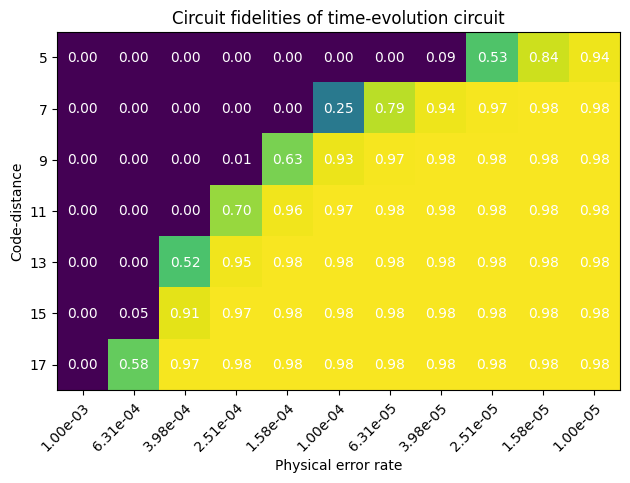

In [12]:
import numpy as np

import matplotlib.pyplot as plt


fig, ax = plt.subplots()
im = ax.imshow(log_fidelities, norm=plt.Normalize(-1.0, 0.0))

ax.set_xticks(range(len(error_rates)), labels=[f"{e:.2e}" for e in error_rates],
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(code_distances)), labels=code_distances)

for i in range(len(code_distances)):
    for j in range(len(error_rates)):
        text = ax.text(j, i, f"{fidelities[i, j]:.2f}",
                       ha="center", va="center", color="w")

ax.set_ylabel('Code-distance')
ax.set_xlabel('Physical error rate')
ax.set_title("Circuit fidelities of time-evolution circuit")
fig.tight_layout()
plt.show()

Clearly there is a sharp transition between low and high fidelity circuit evaluation. The general tendency for QEC is that given some circuit to be executed, the architecture either supports it well or not at all. The remaining error that limits the fidelity to 0.98 comes from the SK decomposition error.

If we know the application and the logical circuit depth, we have to pick a code distance that can support it with the given physical error rate. As an example we can consider what happens when we set the physical error rate to

## Rules of the surface code

Generally the surface code allows different implementations in terms of the ways that error corrected logical qubit patches can interact. However, whichever strategy is chosen the overall steps are

- Clifford gates are implemented using lattice surgery where possible and transversally otherwise
- T-gates are implemented by consuming magic states through a gate-teleportation protocol
- Magic state factories must continuously create magic states for consumption by data blocks which perform operation on several qubits at once

In this section we will discuss the different choices in data-blocks and experiment with three different layouts - Compact, intermediate and fast. To read more about them we refer to Litinski's [A Game of Surface Codes](https://quantum-journal.org/papers/q-2019-03-05-128/).

![operations on the surface code](surface_code_rules.png)

### Types of operations implemented on patches

The following operations can be done directly through manipulations of the surface code qubits while quantum error correction is performed concurrently.

1. Qubit initialization - either as single qubit patches or two-qubit patches, but only in specific states unless some finite error is tolerated.
2. Qubit measurement - This can be done as single-patch, two-pach or multi-patch measurements, each with some differences in how they are carried out. Multi-patch measurements typically involve creating an ancilla-patch to carry out the measurements, where the ancilla determines the basis.
3. Edges and corner of a patch can be moved to change its size and to reshape its boundary - before performing multi-qubit measurement, this is often required.

The figure above summarizes these operations briefly. Importantly, they can be performed in a constant number of time-steps, where each time-step is $O(d)$ quantum error correction cycles. The required foot-print depends on the type of data-block chosen and the number of qubits. Using the multi-patch measurement, gate teleportation can be implemented and by doing so arbitrary quantum computation can be carried out through the Clifford+T decomposition with by using magic states for the measurements.

The required number of tiles $s$ and the code distance $d$ determines the physical footprint required as $sd^2$, while the time cost is $td$, i.e. the number of time-steps times the code distance. The product of the physical footprint and time-cost yields the space-time cost, $std^3$ - as a rule of thumb the space-time resources required therefore scales as $d^3$.

Thus for arbitrary quantum computation to be achieved it is important to have data processing blocks available which perform the above mentioned operations while being fed a steady supply of magic states. Optimizing for the lowest execution time has been shown to be NP-hard, so rather than finding optimal layouts for the logical patches and magic state distillation units, a heuristic is used where different data-blocks are considered based on their trade-offs between execution time and physical footprint. We do not go into detail here on magic state distillation - it is assumed that magic state distillation is available through a dedicated magic state distillation unit.

## Data blocks

We will here discuss the three different data-blocks simulated by QURI VM. In the following we use figures from the aforementioned [A Game of Surface Codes](https://quantum-journal.org/papers/q-2019-03-05-128/), and we also describe the time required for each step using their convention, i.e. one time-step for a code distance $d$ patch requires $d$ error correction cycles (in addition to some constant term, which will be ignored).

### Compact

![compact data-block](compact.png)

The compact block performs logical operations on $n$ qubits, but its footprint is $1.5n + 3$ tiles. Because the patches here only take up one tile, they may only expose one edge to the ancilla region, and because of this, by default only $Z$ measurements can be performed. In order to do $X$ meausrements the qubits must be rotated, which takes up to 3 error correction cycles. In order to perform $Y$ measurements, the measurement has to be decomposed as a series of single-qubit rotations and $X$ or $Z$ measurements.

### Intermediate


![intermediate and fast data-blocks](intermediate_fast.png)

The intermediate block requires $2.5n + 4$ tiles and requires at most 5 time-steps to execute an instruction. It is expected to be faster on average compared to the compact block because data-patches can be rotated in parallel and the rotations themselves only take 2 time-steps.

### Fast

Fast blocks are laid out in such a way that both the $Z$ and $X$ boundaries of each data-patch is exposed at any time. This means that rotations are not required when multi-patch measurements are taken. Each patch is a two-qubit patch with edges arranged so that one qubit is accessible from the left boundary and another one is accessible from the right one. The fast block has the lowest space-time cost of the three designs mentioned, so whenever feasible it is preferrable over other schemes.

In [8]:
mode_blocks = ["compact", "intermediate", "fast"]
N_QUBITS = 8

code_distances = [5, 7, 9, 11, 13, 15, 17]

time_evo_trotter = circuit_factory(EVOLUTION_TIME, N_QUBITS, N_TROTTER)
time_evo_trotter_transpiled = vm.transpile(time_evo_trotter)
physical_qubits = np.zeros((len(mode_blocks), len(code_distances)))
latencies = np.zeros((len(mode_blocks), len(code_distances)))

for i, block in enumerate(mode_blocks):
    for j, d in enumerate(code_distances):
        vm, device_property = get_vm(qubit_count=N_QUBITS, code_distance=d, mode_block=block)
        analysis = vm.analyze(time_evo_trotter_transpiled)
        physical_qubits[i,j] = device_property.physical_qubit_count
        latencies[i,j] = analysis.latency.in_ns()


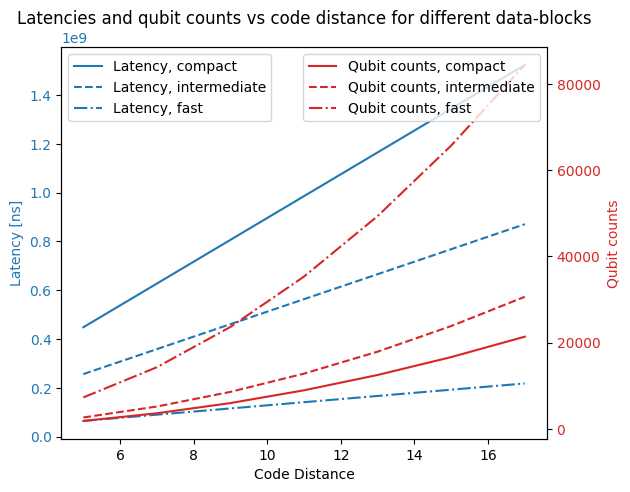

In [9]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:blue'
linestyles = ['-', '--', '-.']

ax1.set_xlabel('Code Distance')
ax1.set_ylabel('Latency [ns]', color=color)
for i, block in enumerate(mode_blocks):
    ax1.plot(code_distances, latencies[i], label=f'Latency, {block}', color=color, linestyle=linestyles[i])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Qubit counts', color=color)
for i, block in enumerate(mode_blocks):
    ax2.plot(code_distances, physical_qubits[i], label=f'Qubit counts, {block}', color=color, linestyle=linestyles[i])
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Latencies and qubit counts vs code distance for different data-blocks')
plt.show()